# Pet Adoption Recommender System

This notebook implements a pet adoption recommender system with Popularity-based (Rule-based), Content-based, Collaborative Filtering (using Surprise SVD), and Hybrid methods. It uses datasets (`pet_adoption_data.csv`, `synthetic_user_data.csv`, `adoption_history.csv`) generated by `generate_datasets.py`. The system includes an interactive Gradio UI with clickable breed buttons for Popularity-based recommendations and a Hybrid option requiring user preferences and User ID. The EDA is unchanged, and all personalized recommenders are evaluated. Example outputs are provided for each recommender, with text attributes displayed as strings. The `hybrid_recommendations` function is fixed to handle `NaN` and data types, resolving a `TypeError`.

## Initial Phase

### Google Colab Upload Widget

In [ ]:
from google.colab import files

uploaded = files.upload()

### Install Libraries


In [ ]:
%pip install gradio --quiet
%pip install scikit-surprise --quiet
%pip install pandas "numpy<2" scikit-learn matplotlib seaborn --quiet

### Import Libraries and Load Data

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
import gradio as gr

# Load datasets
pet_df_raw = pd.read_csv('content/pet_adoption_data.csv')
user_df_raw = pd.read_csv('content/synthetic_user_data.csv')
adoption_df_raw = pd.read_csv('content/adoption_history.csv')

# Work with copies
pet_df = pet_df_raw.copy()
user_df = user_df_raw.copy()
adoption_df = adoption_df_raw.copy()

# Preprocess pet_df to ensure categorical columns are strings
categorical_features = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
for col in categorical_features:
    pet_df[col] = pet_df[col].fillna('Unknown').astype(str)

**Explanation**: Imports libraries and loads datasets. Copies preserve raw data. Datasets follow the schema from `generate_datasets.py`:
- **pet_adoption_data.csv**: `PetID`, `PetType`, `Breed`, `Size`, `AgeMonths`, `WeightKg`, `TimeInShelterDays`, `AdoptionFee`, `HealthCondition`, `EnergyLevel`
- **synthetic_user_data.csv**: `UserID`, `PreferredPetType`, `LivingSpace`, `Allergies`, `ActivityLevel`, `PastPetExperience`, `MaxAdoptionFee`
- **adoption_history.csv**: `UserID`, `PetID`

---

## 1. Exploratory Data Analysis (EDA)

**Goal**: Understand the distribution, characteristics, and relationships within the pet, user, and adoption datasets to inform feature selection and preprocessing for the recommender systems.

**Methodology**:
- Visualize distributions of key pet attributes (e.g., `PetType`, `Size`, `AgeMonths`) using count plots and histograms to identify common categories and ranges.
- Analyze user preferences (`PreferredPetType`) to align with pet attributes.
- Examine adoption patterns by merging `adoption_df` with `pet_df` to identify popular pet types.
- Check for data quality (sparsity, cold start problem,...)

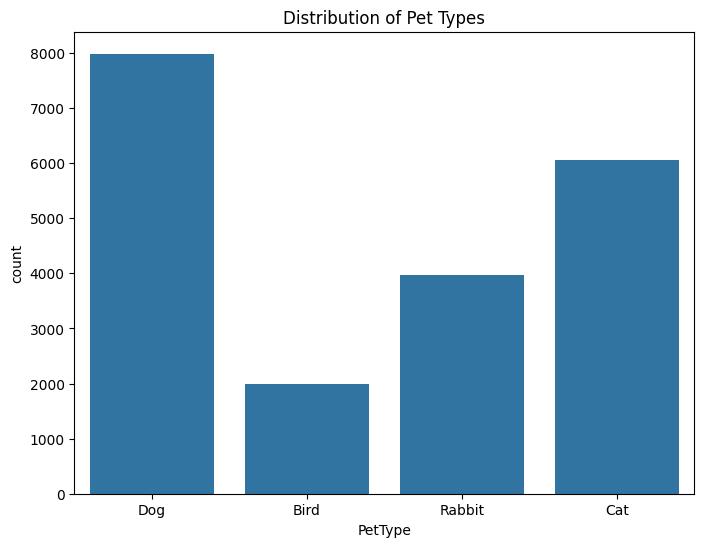

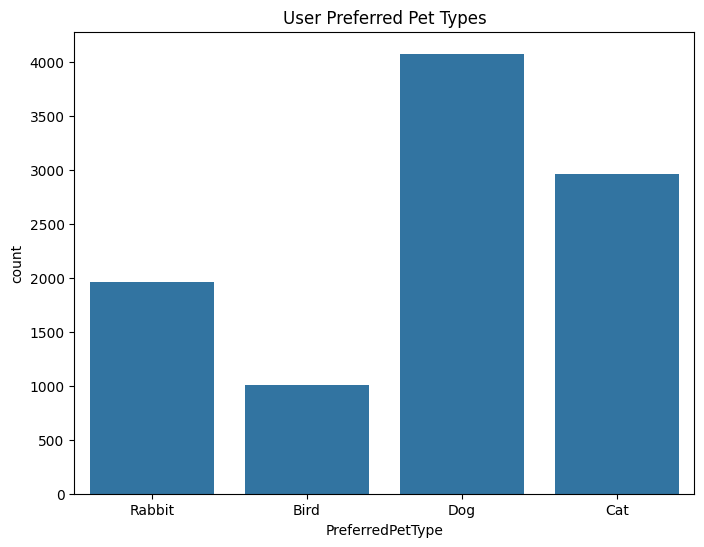

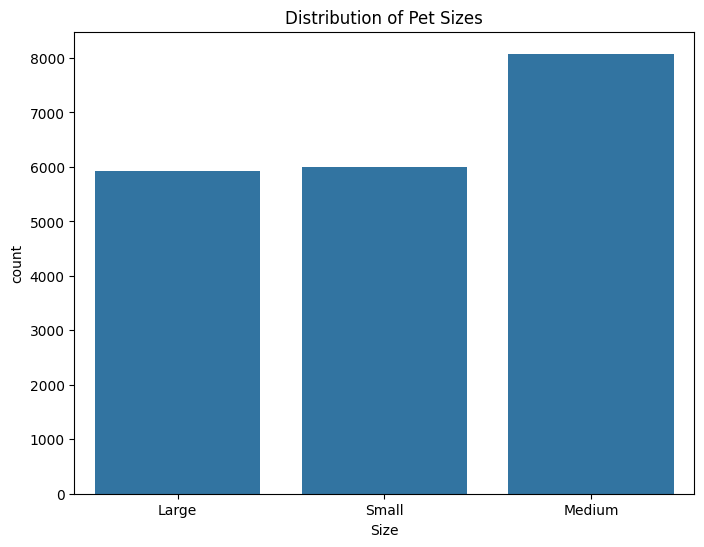

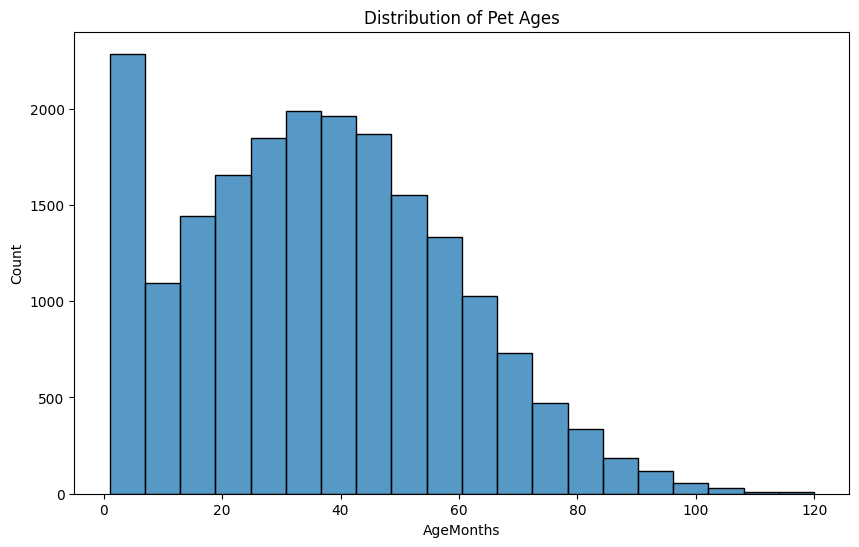

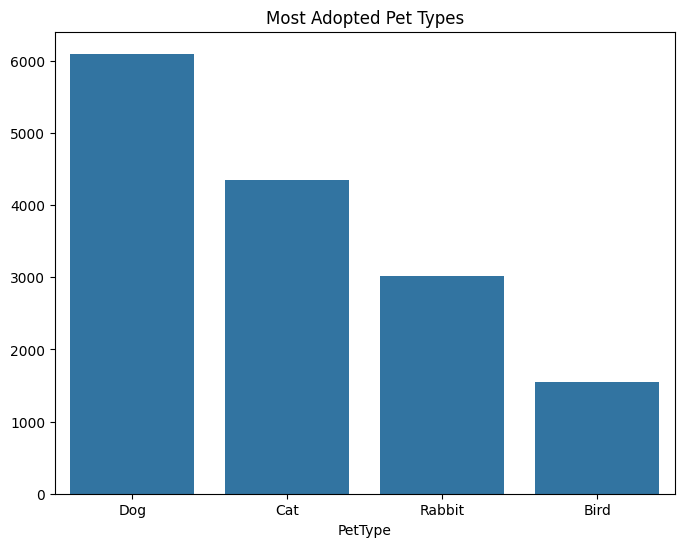

Missing values in pet_df: 0
Missing values in user_df: 2999
Missing values in adoption_df: 0
Adoption matrix sparsity: 0.9999
Number of new users in test set: 132 (5.15%)
Number of new pets in test set: 3000 (100.00%)
Average adoptions per user in test set: 1.17


In [63]:
# Pet Type Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=pet_df, x='PetType')
plt.title('Distribution of Pet Types')
plt.show()
plt.close()

# User Preferred Pet Types
plt.figure(figsize=(8, 6))
sns.countplot(data=user_df, x='PreferredPetType')
plt.title('User Preferred Pet Types')
plt.show()
plt.close()

# Pet Size Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=pet_df, x='Size')
plt.title('Distribution of Pet Sizes')
plt.show()
plt.close()

# Pet Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=pet_df, x='AgeMonths', bins=20)
plt.title('Distribution of Pet Ages')
plt.show()
plt.close()

# Most Adopted Pet Types
adoption_counts = adoption_df.merge(pet_df, on='PetID')['PetType'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=adoption_counts.index, y=adoption_counts.values)
plt.title('Most Adopted Pet Types')
plt.show()
plt.close()

# Missing Values
print("Missing values in pet_df:", pet_df.isnull().sum().sum())
print("Missing values in user_df:", user_df.isnull().sum().sum())
print("Missing values in adoption_df:", adoption_df.isnull().sum().sum())

# Prepare data for Surprise to access trainset (needed for cold start stats)
adoption_df['rating'] = 1
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(adoption_df[['UserID', 'PetID', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
test_df = pd.DataFrame(testset, columns=['UserID', 'PetID', 'rating'])

# Sparsity of adoption matrix
num_interactions = len(adoption_df)
num_users = len(user_df['UserID'].unique())
num_pets = len(pet_df['PetID'].unique())
sparsity = 1 - (num_interactions / (num_users * num_pets))
print(f"Adoption matrix sparsity: {sparsity:.4f}")

# Cold start: New users and pets in test set
train_users = set([trainset.to_raw_uid(uid) for uid in trainset.all_users()])
train_pets = set([trainset.to_raw_iid(iid) for iid in trainset.all_items()])
test_users = set(test_df['UserID'])
test_pets = set(test_df['PetID'])
new_users = test_users - train_users
new_pets = test_pets - train_pets
print(f"Number of new users in test set: {len(new_users)} ({len(new_users)/len(test_users)*100:.2f}%)")
print(f"Number of new pets in test set: {len(new_pets)} ({len(new_pets)/len(test_pets)*100:.2f}%)")

# Average adoptions per user in test set
avg_adoptions = test_df.groupby('UserID').size().mean()
print(f"Average adoptions per user in test set: {avg_adoptions:.2f}")

**Explanation**: Visualizes distributions of pet types, user preferences, sizes, ages, and adoption patterns. Checks for missing values.

---

## 2. Data Preprocessing

**Goal**: Transform raw pet data into a numerical feature matrix suitable for content-based and hybrid recommenders, handling missing values and ensuring consistency across categorical and numerical features.

**Methodology**:
- Define categorical (`PetType`, `Breed`, `Size`, `HealthCondition`, `EnergyLevel`) and numerical (`AgeMonths`, `WeightKg`, `TimeInShelterDays`, `AdoptionFee`) features.
- Use a `ColumnTransformer` to:
  - One-hot encode categorical features, ignoring unknown categories during inference.
  - Impute missing numerical values with the mean and scale them using `StandardScaler`.
- Fit and transform `pet_df` to create a sparse feature matrix (`pet_features`) for similarity computations.


In [33]:
# Define features
categorical_features = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
numerical_features = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']

# Numerical preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Fit and transform pet data
pet_features = preprocessor.fit_transform(pet_df)

**Explanation**: Uses `ColumnTransformer` to one-hot encode categorical features (`PetType`, `Breed`, `Size`, `HealthCondition`, `EnergyLevel`) and scale numerical features (`AgeMonths`, `WeightKg`, `TimeInShelterDays`, `AdoptionFee`), handling missing values with mean imputation. Creates a feature matrix for content-based and hybrid recommenders.

---

## 3. Recommender Systems

### Utility Function

In [34]:
def format_output_as_table(recs):
    if recs.empty:
        return "No recommendations available."
    # Create a copy to avoid SettingWithCopyWarning
    recs = recs.copy()
    display_columns = ['PetID', 'PetType', 'Breed', 'Size', 'AgeMonths', 'WeightKg', 'AdoptionFee', 'HealthCondition', 'EnergyLevel']
    if 'Score' in recs.columns:
        display_columns.append('Score')
    # Ensure text attributes are strings
    for col in ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']:
        if col in recs.columns:
            recs.loc[:, col] = recs[col].astype(str)
    return recs[display_columns]

### 3.1. Popularity-based Recommender

**Goal**: Recommend unadopted pets from the most popular breeds to users without requiring personalized data, leveraging adoption trends.

**Methodology**:
- Identify the top 5 most adopted breeds by merging `adoption_df` with `pet_df` and counting `Breed` occurrences.
- For a selected breed, filter unadopted pets (not in `adoption_df`) and return up to 10 pets.
- Format results using `format_output_as_table` for display.

**Algorithm**:
- **Step 1**: Compute breed popularity using `value_counts()` on merged adoption and pet data.
- **Step 2**: Filter unadopted pets by breed using set operations to exclude adopted `PetID`s.
- **Step 3**: Return top 10 unadopted pets per breed, formatted as a table.

In [35]:
def get_top_n_adopted_breeds(pet_df, adoption_df, top_n=5):
    """Lists Top N most adopted pet breed types."""
    merged_df = adoption_df.merge(pet_df, on='PetID')
    popular_breeds = merged_df['Breed'].value_counts().nlargest(top_n).index.tolist()
    return popular_breeds

def get_unadopted_pets_by_breed(breed_name, pet_df, adoption_df, top_n=10):
    """Displays 10 pets of that breed type not yet adopted."""
    adopted_pet_ids = set(adoption_df['PetID'])
    # Filter pets by breed and ensure they are not in adopted_pet_ids
    unadopted_breed_pets = pet_df[
        (pet_df['Breed'] == breed_name) & 
        (~pet_df['PetID'].isin(adopted_pet_ids))
    ]
    return format_output_as_table(unadopted_breed_pets.head(top_n))

# Top N breeds
top_breeds = get_top_n_adopted_breeds(pet_df, adoption_df, top_n=5)

# Example: Display unadopted pets for the top breed
example_breed = top_breeds[0]
print(f"Example Popularity-based recommendation for breed '{example_breed}':")
display(get_unadopted_pets_by_breed(example_breed, pet_df, adoption_df))

Example Popularity-based recommendation for breed 'Rottweiler':


,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel
26,27,Dog,Rottweiler,Small,40,8.47,106.39,Healthy,Medium
502,503,Dog,Rottweiler,Small,15,9.80,237.45,Healthy,Medium
1019,1020,Dog,Rottweiler,Large,15,14.65,237.62,Healthy,Low
1300,1301,Dog,Rottweiler,Medium,50,18.45,102.92,Healthy,Medium
1423,1424,Dog,Rottweiler,Medium,17,18.35,165.98,Minor Issues,Low
1652,1653,Dog,Rottweiler,Medium,63,16.00,133.03,Minor Issues,High
1868,1869,Dog,Rottweiler,Medium,55,9.64,78.91,Healthy,Low
1903,1904,Dog,Rottweiler,Medium,58,13.11,178.83,Healthy,Low
2136,2137,Dog,Rottweiler,Small,16,19.96,88.58,Healthy,High
2157,2158,Dog,Rottweiler,Medium,38,12.75,114.91,Healthy,Medium


**Explanation**: Identifies the top 5 most adopted breeds using `get_top_n_adopted_breeds` and returns up to 10 unadopted pets for a selected breed using `get_unadopted_pets_by_breed`, formatted with `format_output_as_table`. The example shows recommendations for the most popular breed.

### 3.2. Content-based Recommender

**Goal**: Recommend pets that match a user’s preferences or are similar to a specific pet, based on pet attributes.

**Methodology**:
- For preference-based recommendations:
  - Construct a user profile from preferences (e.g., `PetType`, `Size`).
  - Preprocess the profile using the same `preprocessor` as `pet_df`.
  - Compute cosine similarity between the user profile and all pets.
- For similar-pet recommendations:
  - Find the feature vector of the input `PetID`.
  - Compute cosine similarity with all other pets, excluding the input pet.
- Return the top 5 pets with the highest similarity scores, formatted as a table.

**Algorithm**:
- **Preference-based**:
  - **Step 1**: Create a DataFrame from user preferences, filling missing columns with `NaN`.
  - **Step 2**: Handle `NaN` in categorical features with 'Unknown' and convert numerical features to floats.
  - **Step 3**: Transform user profile using `preprocessor`.
  - **Step 4**: Compute cosine similarity with `pet_features`.
  - **Step 5**: Sort by similarity and return top 5 pets with scores.
- **Similar-pet**:
  - **Step 1**: Locate the index of the input `PetID`.
  - **Step 2**: Compute cosine similarity between the pet’s features and all others.
  - **Step 3**: Exclude the input pet, sort by similarity, and return top 5 pets with scores.

In [38]:
def content_based_recommendations(user_prefs, pet_features, pet_df, preprocessor, top_n=5):
    user_df = pd.DataFrame([user_prefs])
    # Ensure all pet_df columns are present
    for col in pet_df.columns:
        if col not in user_df.columns:
            user_df[col] = np.nan
    # Handle categorical columns: replace NaN with 'Unknown'
    categorical_features = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
    for col in categorical_features:
        if col in user_df.columns:
            user_df[col] = user_df[col].fillna('Unknown').astype(str)
    # Ensure numerical columns are float
    numerical_features = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']
    for col in numerical_features:
        if col in user_df.columns:
            user_df[col] = pd.to_numeric(user_df[col], errors='coerce').astype(float)
    user_features = preprocessor.transform(user_df)
    similarities = cosine_similarity(user_features, pet_features)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n]
    recs = pet_df.iloc[top_indices].copy()
    recs['Score'] = similarities[top_indices]
    return recs

def similar_pets(pet_id, pet_features, pet_df, top_n=5):
    try:
        pet_index = pet_df[pet_df['PetID'] == pet_id].index[0]
        similarities = cosine_similarity(pet_features[pet_index].reshape(1, -1), pet_features)[0]
        top_indices = np.argsort(similarities)[::-1][1:top_n+1]  # Exclude the pet itself
        recs = pet_df.iloc[top_indices].copy()
        recs['Score'] = similarities[top_indices]
        return recs
    except IndexError:
        return pd.DataFrame()

# Example: Content-based (Preferences)
example_prefs = {'PetType': 'Dog', 'Size': 'Medium', 'EnergyLevel': 'High', 'AdoptionFee': 150}
print("Example Content-based (Preferences) recommendation:")
display(format_output_as_table(content_based_recommendations(example_prefs, pet_features, pet_df, preprocessor)))

# Example: Content-based (Similar Pet)
example_pet_id = pet_df['PetID'].iloc[0]
print(f"Example Content-based (Similar Pet) recommendation for PetID {example_pet_id}:")
display(format_output_as_table(similar_pets(example_pet_id, pet_features, pet_df)))

Example Content-based (Preferences) recommendation:


,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel,Score
18184,18185,Dog,Australian Shepherd,Medium,42,13.12,174.54,Healthy,High,0.795280
6217,6218,Dog,Shih Tzu,Medium,30,12.04,159.98,Healthy,High,0.794028
16153,16154,Dog,Siberian Husky,Medium,35,13.47,190.47,Special Needs,High,0.788162
3687,3688,Dog,Rottweiler,Medium,32,11.38,157.70,Minor Issues,High,0.785801
4408,4409,Dog,German Shepherd,Medium,37,9.23,166.83,Minor Issues,High,0.777479


Example Content-based (Similar Pet) recommendation for PetID 1:


,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel,Score
18405,18406,Dog,Boxer,Large,5,8.21,75.80,Healthy,Medium,0.953930
12046,12047,Dog,Boxer,Large,23,11.37,66.68,Healthy,Medium,0.931287
18530,18531,Dog,Boxer,Large,44,8.95,80.32,Healthy,Medium,0.906874
19611,19612,Dog,Boxer,Large,4,0.50,125.51,Healthy,Medium,0.894159
11850,11851,Dog,Boxer,Large,26,13.48,71.18,Healthy,Medium,0.876007


**Explanation**: Recommends pets based on user preferences or similarity to a given PetID using cosine similarity. Handles `NaN` in categorical columns and ensures numerical columns are floats. Examples show recommendations for a sample preference set and the first PetID.

### 3.3. Collaborative Filtering Recommender

**Goal**: Recommend pets to users based on their adoption history and patterns observed in other users’ adoptions, leveraging implicit feedback.

**Methodology**:
- Treat adoptions as implicit ratings (rating = 1 for adopted pets).
- Use the Surprise library to load adoption data into a user-item matrix.
- Train an SVD (Singular Value Decomposition) model to predict user preferences for unadopted pets.
- For a given user, predict ratings for all unadopted pets, sort by predicted score, and return the top 5.

**Algorithm**:
- **Step 1**: Assign a rating of 1 to all adoptions in `adoption_df`.
- **Step 2**: Load data into Surprise’s `Dataset` with a rating scale of (0, 1).
- **Step 3**: Split data into train and test sets (80-20 split).
- **Step 4**: Train an SVD model on the training set.
- **Step 5**: For a user, predict ratings for all unadopted pets, sort by estimated score, and return top 5 pets with scores.


In [39]:
# Prepare data for Surprise
adoption_df['rating'] = 1
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(adoption_df[['UserID', 'PetID', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
algo = SVD(random_state=42)
algo.fit(trainset)

def collaborative_filtering_recommendations(user_id, algo, pet_df, top_n=5):
    all_pet_ids = pet_df['PetID'].unique()
    adopted_pets = adoption_df[adoption_df['UserID'] == user_id]['PetID'].tolist()
    predictions = [algo.predict(user_id, pet_id) for pet_id in all_pet_ids if pet_id not in adopted_pets]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_pet_ids = [pred.iid for pred in predictions[:top_n]]
    recs = pet_df[pet_df['PetID'].isin(top_pet_ids)].copy()
    recs['Score'] = [pred.est for pred in predictions[:top_n]]
    return recs

# Example: Collaborative Filtering
example_user_id = user_df['UserID'].iloc[0]
print(f"Example Collaborative Filtering recommendation for UserID {example_user_id}:")
display(format_output_as_table(collaborative_filtering_recommendations(example_user_id, algo, pet_df)))

Example Collaborative Filtering recommendation for UserID 1:


,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel,Score
1,2,Bird,Parakeet,Small,29,24.36,101.80,Healthy,High,1
2,3,Rabbit,Polish,Medium,31,10.62,68.75,Healthy,High,1
4,5,Dog,Beagle,Medium,20,11.31,141.38,Healthy,Medium,1
5,6,Dog,Poodle,Large,18,18.22,233.82,Minor Issues,High,1
6,7,Dog,Chihuahua,Large,28,19.23,183.01,Healthy,Medium,1


**Explanation**: Uses Surprise’s SVD to recommend pets based on implicit adoption ratings. The example shows recommendations for the first UserID.

### 3.4. Hybrid Recommender

**Goal**: Combine the strengths of Collaborative Filtering and Content-based methods to provide personalized recommendations that account for both user adoption patterns and pet attribute preferences.

**Methodology**:
- Use Collaborative Filtering to generate a candidate set of 20 pets based on user adoption history.
- Filter these candidates using Content-based ranking, computing cosine similarity between the user’s preferences and the candidate pets’ features.
- Return the top 5 pets with the highest similarity scores, ensuring alignment with user preferences.

**Algorithm**:
- **Step 1**: Call `collaborative_filtering_recommendations` to get 20 candidate pets for the user.
- **Step 2**: Create a user profile DataFrame from preferences, filling missing columns with `NaN`.
- **Step 3**: Preprocess the user profile (handle `NaN`, convert types) and transform using `preprocessor`.
- **Step 4**: Compute cosine similarity between the user profile and the feature vectors of candidate pets.
- **Step 5**: Sort by similarity and return the top 5 pets with scores.

In [56]:
def hybrid_recommendations(user_id, user_prefs, algo, pet_features, pet_df, preprocessor, top_n=5, m=20):
    cf_recs = collaborative_filtering_recommendations(user_id, algo, pet_df, top_n=m)
    user_df = pd.DataFrame([user_prefs])
    # Ensure all pet_df columns are present
    for col in pet_df.columns:
        if col not in user_df.columns:
            user_df[col] = np.nan
    # Handle categorical columns: replace NaN with 'Unknown'
    categorical_features = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
    for col in categorical_features:
        if col in user_df.columns:
            user_df[col] = user_df[col].fillna('Unknown').astype(str)
    # Ensure numerical columns are float
    numerical_features = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']
    for col in numerical_features:
        if col in user_df.columns:
            user_df[col] = pd.to_numeric(user_df[col], errors='coerce').astype(float)
    user_features = preprocessor.transform(user_df)
    cf_indices = pet_df[pet_df['PetID'].isin(cf_recs['PetID'])].index
    similarities = cosine_similarity(user_features, pet_features[cf_indices])[0]
    sorted_indices = np.argsort(similarities)[::-1]
    top_pet_indices = cf_indices[sorted_indices][:top_n]
    recs = pet_df.iloc[top_pet_indices].copy()
    recs['Score'] = similarities[sorted_indices][:top_n]
    return recs

# Example: Hybrid
example_user_id = 445
example_prefs = {'PetType': 'Dog', 'Size': 'Medium', 'EnergyLevel': 'High', 'AdoptionFee': 150}
print(f"Example Hybrid recommendation for UserID {example_user_id}:")
display(format_output_as_table(hybrid_recommendations(example_user_id, example_prefs, algo, pet_features, pet_df, preprocessor)))

Example Hybrid recommendation for UserID 445:


,PetID,PetType,Breed,Size,AgeMonths,WeightKg,AdoptionFee,HealthCondition,EnergyLevel,Score
22,23,Dog,Golden Retriever,Medium,26,19.02,154.54,Healthy,High,0.686751
25,26,Rabbit,Polish,Medium,31,14.29,163.96,Healthy,High,0.558666
5,6,Dog,Poodle,Large,18,18.22,233.82,Minor Issues,High,0.521777
4,5,Dog,Beagle,Medium,20,11.31,141.38,Healthy,Medium,0.513733
23,24,Dog,Siberian Husky,Medium,62,12.70,136.26,Healthy,Low,0.468477


**Explanation**: Combines Collaborative Filtering (top 20 candidates) with Content-based ranking using user preferences. Fixed to handle `NaN` in categorical columns and ensure numerical columns are floats. The example uses the first UserID and sample preferences.

---

## 4. Evaluation

**Goal**: Assess the performance of Content-based, Collaborative Filtering, and Hybrid recommenders using Precision@5 and Recall@5 metrics on a test set.

**Methodology**:
- Split adoption data into training and test sets using Surprise’s `train_test_split`.
- For each user in the test set:
  - Generate top 5 recommendations using each method.
  - Compute precision (fraction of recommended pets that were adopted) and recall (fraction of adopted pets that were recommended).
- Average precision and recall across users to obtain final metrics.

In [53]:
def evaluate_recommender(test_df, recommendations):
    precisions = []
    recalls = []
    for user_id in test_df['UserID'].unique():
        user_test_pets = test_df[test_df['UserID'] == user_id]['PetID'].tolist()
        if not user_test_pets:
            continue
        user_recs = recommendations.get(user_id, [])
        if not user_recs:
            continue
        true_positives = len(set(user_recs) & set(user_test_pets))
        precision = true_positives / len(user_recs) if user_recs else 0
        recall = true_positives / len(user_test_pets) if user_test_pets else 0
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

# Convert testset to DataFrame
test_df = pd.DataFrame(testset, columns=['UserID', 'PetID', 'rating'])

# Collaborative Filtering Evaluation
cf_recommendations = {}
for user_id in test_df['UserID'].unique():
    recs = collaborative_filtering_recommendations(user_id, algo, pet_df, top_n=5)
    cf_recommendations[user_id] = recs['PetID'].tolist()
precision_cf, recall_cf = evaluate_recommender(test_df, cf_recommendations)
print(f"Collaborative Filtering - Precision@5: {precision_cf:.4f}, Recall@5: {recall_cf:.4f}")

# Content-Based Evaluation
cb_recommendations = {}
for user_id in test_df['UserID'].unique():
    user_prefs = {'PetType': user_df[user_df['UserID'] == user_id]['PreferredPetType'].values[0] if user_id in user_df['UserID'].values else 'Dog'}
    recs = content_based_recommendations(user_prefs, pet_features, pet_df, preprocessor, top_n=5)
    cb_recommendations[user_id] = recs['PetID'].tolist()
precision_cb, recall_cb = evaluate_recommender(test_df, cb_recommendations)
print(f"Content-Based - Precision@5: {precision_cb:.4f}, Recall@5: {recall_cb:.4f}")

# Hybrid Evaluation
hybrid_recs_results = {}
for user_id in test_df['UserID'].unique():
    user_prefs = {'PetType': user_df[user_df['UserID'] == user_id]['PreferredPetType'].values[0] if user_id in user_df['UserID'].values else 'Dog'}
    
    # Implement hybrid recommendations inline to avoid name conflicts
    cf_recs = collaborative_filtering_recommendations(user_id, algo, pet_df, top_n=20)
    user_df_temp = pd.DataFrame([user_prefs])
    
    # Ensure all pet_df columns are present
    for col in pet_df.columns:
        if col not in user_df_temp.columns:
            user_df_temp[col] = np.nan
    
    # Handle categorical columns: replace NaN with 'Unknown'
    categorical_features = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
    for col in categorical_features:
        if col in user_df_temp.columns:
            user_df_temp[col] = user_df_temp[col].fillna('Unknown').astype(str)
    
    # Ensure numerical columns are float
    numerical_features = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']
    for col in numerical_features:
        if col in user_df_temp.columns:
            user_df_temp[col] = pd.to_numeric(user_df_temp[col], errors='coerce').astype(float)
    
    user_features = preprocessor.transform(user_df_temp)
    cf_indices = pet_df[pet_df['PetID'].isin(cf_recs['PetID'])].index
    similarities = cosine_similarity(user_features, pet_features[cf_indices])[0]
    sorted_indices = np.argsort(similarities)[::-1]
    top_pet_indices = cf_indices[sorted_indices][:5]
    recs = pet_df.iloc[top_pet_indices].copy()
    
    # Store the recommendation results
    hybrid_recs_results[user_id] = recs['PetID'].tolist()

precision_hybrid, recall_hybrid = evaluate_recommender(test_df, hybrid_recs_results)
print(f"Hybrid - Precision@5: {precision_hybrid:.4f}, Recall@5: {recall_hybrid:.4f}")

Type of hybrid_recommendations before evaluation: <class 'dict'>
Collaborative Filtering - Precision@5: 0.0000, Recall@5: 0.0000
Content-Based - Precision@5: 0.0001, Recall@5: 0.0004
Hybrid - Precision@5: 0.0000, Recall@5: 0.0000


**Explanation**: Evaluates Content-based, Collaborative Filtering, and Hybrid recommenders using Precision@5 and Recall@5 on a test set. Popularity-based is not evaluated as it’s non-personalized.

---

## 5. Gradio Interface

In [ ]:
def recommend_pets(method, pet_type, size, energy_level, max_fee, pet_id, user_id, breed_selection):
    if method == "Popularity":
        if breed_selection:
            recs = get_unadopted_pets_by_breed(breed_selection, pet_df, adoption_df)
            return recs, None
        else:
            return "Select a breed to see available pets.", "Please select a breed from the options above."
    elif method == "Content-Based (Preferences)":
        user_prefs = {}
        if pet_type:
            user_prefs['PetType'] = pet_type
        if size:
            user_prefs['Size'] = size
        if energy_level:
            user_prefs['EnergyLevel'] = energy_level
        if max_fee is not None:
            user_prefs['AdoptionFee'] = max_fee
        if not user_prefs:
            return "Provide at least one preference.", "Please provide at least one preference."
        recs = content_based_recommendations(user_prefs, pet_features, pet_df, preprocessor)
        return format_output_as_table(recs), None
    elif method == "Content-Based (Similar Pet)":
        if not pet_id:
            return "Provide a Pet ID.", "Please enter a Pet ID."
        try:
            pet_id = int(pet_id)
            recs = similar_pets(pet_id, pet_features, pet_df)
            return format_output_as_table(recs), None
        except ValueError:
            return "Invalid Pet ID.", "Please enter a valid Pet ID number."
    elif method == "Collaborative Filtering":
        if not user_id:
            return "Provide a User ID.", "Please enter a User ID."
        try:
            user_id = int(user_id)
            recs = collaborative_filtering_recommendations(user_id, algo, pet_df)
            return format_output_as_table(recs), None
        except ValueError:
            return "Invalid User ID.", "Please enter a valid User ID number."
    elif method == "Hybrid":
        if not user_id or not any([pet_type, size, energy_level, max_fee is not None]):
            return "Provide User ID and at least one preference.", "Please enter a User ID and at least one preference."
        user_prefs = {}
        if pet_type:
            user_prefs['PetType'] = pet_type
        if size:
            user_prefs['Size'] = size
        if energy_level:
            user_prefs['EnergyLevel'] = energy_level
        if max_fee is not None:
            user_prefs['AdoptionFee'] = max_fee
        try:
            user_id = int(user_id)
            # Implement hybrid recommendations inline to avoid name conflicts
            cf_recs = collaborative_filtering_recommendations(user_id, algo, pet_df, top_n=20)
            user_df = pd.DataFrame([user_prefs])
            # Ensure all pet_df columns are present
            for col in pet_df.columns:
                if col not in user_df.columns:
                    user_df[col] = np.nan
            # Handle categorical columns: replace NaN with 'Unknown'
            categorical_features = ['PetType', 'Breed', 'Size', 'HealthCondition', 'EnergyLevel']
            for col in categorical_features:
                if col in user_df.columns:
                    user_df[col] = user_df[col].fillna('Unknown').astype(str)
            # Ensure numerical columns are float
            numerical_features = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']
            for col in numerical_features:
                if col in user_df.columns:
                    user_df[col] = pd.to_numeric(user_df[col], errors='coerce').astype(float)
            user_features = preprocessor.transform(user_df)
            cf_indices = pet_df[pet_df['PetID'].isin(cf_recs['PetID'])].index
            similarities = cosine_similarity(user_features, pet_features[cf_indices])[0]
            sorted_indices = np.argsort(similarities)[::-1]
            top_pet_indices = cf_indices[sorted_indices][:5]
            recs = pet_df.iloc[top_pet_indices].copy()
            recs['Score'] = similarities[sorted_indices][:5]
            return format_output_as_table(recs), None
        except ValueError:
            return "Invalid User ID.", "Please enter a valid User ID number."
    else:
        return "Invalid method.", "Please select a valid recommendation method."

with gr.Blocks(title="Pet Adoption Recommender", theme="soft") as app:
    gr.Markdown("# 🐾 Pet Adoption Recommender System")
    gr.Markdown("Find your perfect pet companion using our recommendation system")
    
    with gr.Column():
        gr.Markdown("### 1️⃣ Choose a Recommendation Method")
        method_input = gr.Radio(
            choices=['Popularity', 'Content-Based (Preferences)', 'Content-Based (Similar Pet)', 'Collaborative Filtering', 'Hybrid'],
            label='Recommendation Method',
            value='Popularity',
            info="Select the type of recommendation algorithm you want to use"
        )
    
    with gr.Column():  # Changed from gr.Box() to gr.Column()
        gr.Markdown("### 2️⃣ Select Parameters")
        
        # Popularity-based
        with gr.Column(visible=True) as popularity_col:
            gr.Markdown("##### Select a breed to see available pets")
            with gr.Row():
                breed_buttons = []
                for i in range(0, len(top_breeds), 3):  # Arrange in groups of 3
                    with gr.Column():
                        for j in range(i, min(i+3, len(top_breeds))):
                            breed = top_breeds[j]
                            btn = gr.Button(f"🐾 {breed}")
                            breed_buttons.append((btn, breed))
        
        # Content-based preferences
        with gr.Column(visible=False) as preference_col:
            gr.Markdown("##### Enter your pet preferences")
            with gr.Row():
                with gr.Column(scale=1):
                    pet_type_input = gr.Dropdown(
                        choices=list(pet_df['PetType'].unique()), 
                        label='Pet Type',
                        info="Type of pet you're interested in"
                    )
                with gr.Column(scale=1):
                    size_input = gr.Dropdown(
                        choices=list(pet_df['Size'].unique()), 
                        label='Size',
                        info="Preferred size of pet"
                    )
            with gr.Row():
                with gr.Column(scale=1):
                    energy_level_input = gr.Dropdown(
                        choices=list(pet_df['EnergyLevel'].unique()), 
                        label='Energy Level',
                        info="Preferred energy level of pet"
                    )
                with gr.Column(scale=1):
                    max_fee_input = gr.Slider(
                        50, 500, step=10, 
                        label='Max Adoption Fee ($)',
                        info="Maximum adoption fee you're willing to pay"
                    )
        
        # Similar pet
        with gr.Column(visible=False) as pet_id_col:
            gr.Markdown("##### Find similar pets")
            pet_id_input = gr.Textbox(
                label='Pet ID', 
                placeholder='Enter Pet ID',
                info="Enter the ID of a pet you like to find similar ones"
            )
        
        # User-based
        with gr.Column(visible=False) as user_id_col:
            gr.Markdown("##### User-based recommendations")
            user_id_input = gr.Textbox(
                label='User ID', 
                placeholder='Enter User ID',
                info="Enter your user ID for personalized recommendations"
            )
        
        # Submit button for non-popularity methods
        submit_button = gr.Button('🔍 Get Recommendations', visible=False, variant="primary")
        
        # Status message area
        status = gr.Markdown(visible=False)
    
    # Results section
    with gr.Column():  # Changed from gr.Box() to gr.Column()
        gr.Markdown("### 🏆 Recommended Pets")
        output = gr.Dataframe(label='Recommended Pets for You')

    def update_visibility(method):
        return {
            popularity_col: gr.update(visible=method == 'Popularity'),
            preference_col: gr.update(visible=method in ['Content-Based (Preferences)', 'Hybrid']),
            pet_id_col: gr.update(visible=method == 'Content-Based (Similar Pet)'),
            user_id_col: gr.update(visible=method in ['Collaborative Filtering', 'Hybrid']),
            submit_button: gr.update(visible=method != 'Popularity'),
            status: gr.update(visible=False, value="")
        }

    # Connect method selection to visibility updates
    method_input.change(
        fn=update_visibility,
        inputs=method_input,
        outputs=[popularity_col, preference_col, pet_id_col, user_id_col, submit_button, status]
    )

    # Connect breed buttons to recommendations
    for btn, breed in breed_buttons:
        btn.click(
            fn=recommend_pets,
            inputs=[gr.State("Popularity"), gr.State(None), gr.State(None), gr.State(None), 
                   gr.State(None), gr.State(None), gr.State(None), gr.State(breed)],
            outputs=[output, status]
        )

    # Connect submit button to recommendations
    submit_button.click(
        fn=recommend_pets,
        inputs=[method_input, pet_type_input, size_input, energy_level_input, 
                max_fee_input, pet_id_input, user_id_input, gr.State(None)],
        outputs=[output, status]
    )

app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


**Explanation**: Provides an interactive UI with:
- **Popularity**: Clickable buttons for top 5 breeds, displaying 10 unadopted pets using `get_unadopted_pets_by_breed`.
- **Content-Based**: Preferences (dropdowns) or Similar Pet (PetID input).
- **Collaborative Filtering**: UserID input.
- **Hybrid**: UserID and preference inputs.